In [1]:
%load_ext autoreload
%autoreload 2
    
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax.numpy as jnp
import deepxde as dde

from absl import flags
from ml_collections import config_flags, config_dict
from configs.ts import get_config
from bubble_tools.bubble_tools.bubble_ellipsoid_tools import load_ellipse
from utils import get_dataset
from bubble_tools.aux.package_utils import get_mesh_path
from bubble_tools.bubble_shape_tools.shape_tools import load_mesh
import numpy as np
from bubble_tools.bubble_tools.bubble_constants import get_bubble_frame_from_camera_frame
from mmint_tools.camera_tools.pointcloud_utils import view_pointcloud, tr_pointcloud
from bubble_tools.bubble_shape_tools.shape_tools import get_bubble_tool_contact_points_sdf
import models
from jaxpi.utils import restore_checkpoint
from scipy.interpolate import griddata
import csv
from pathlib import Path
from bubble_tools.bubble_tools.bubble_constants import get_bubble_v2_frame_from_camera_frame
from bubble_tools.bubble_datasets.implemented_datasets.bubble_v2_dataset import BubbleV2Dataset

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-05-16 22:59:17.913498: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Chamfer Distance: 6.0


In [7]:

data_dir = 'data'# Replace this with the path to the data ("/data")
# data_name = 'bubble_v2_tactile_shadowing_data_only_o_45'
data_name = 'bubble_v2_tactile_shadowing_data'

data_path = os.path.join(data_dir, data_name)
dataset = BubbleV2Dataset(data_name=data_path, 
                                    smoothed=True, 
                                    load_cache=False, 
                                    load_trajectories=False, 
                                        load_depth_filtered = True)

indexs = [i for i in range(30)] + [53]
# indexs = [i for i in range(22, 30)]
# indexs = [i for i in range(40,46)]
# indexs = [53]

Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.44it/s]

Data processed


In [8]:
dataset.__len__()

60

In [9]:
def binary_mask_iou(mask1, mask2):
    mask1_area = jnp.count_nonzero(mask1)
    mask2_area = jnp.count_nonzero(mask2)
    intersection = jnp.count_nonzero(jnp.logical_and(mask1, mask2))
    iou = intersection / (mask1_area + mask2_area - intersection)
    print(mask1_area,mask2_area ,intersection)
    return iou

{'IDX': '0', 'log path': './ckpt/0', 'object': 'flower', 'wrench gt': '11.429175309519762', 'wrench est': '9.729071', 'wrench error': '1.7001047', 'p_thres': '2500.0', 'IoU': '0.59751225'}
{'IDX': '1', 'log path': './ckpt/1', 'object': 'y_shape', 'wrench gt': '8.958210604468594', 'wrench est': '10.122303', 'wrench error': '1.1640921', 'p_thres': '2500.0', 'IoU': '0.582458'}
{'IDX': '2', 'log path': './ckpt/2', 'object': 'half_cylinder_r20', 'wrench gt': '10.571094747017986', 'wrench est': '11.783887', 'wrench error': '1.2127924', 'p_thres': '2500.0', 'IoU': '0.5124378'}
{'IDX': '3', 'log path': './ckpt/3', 'object': '90_curve', 'wrench gt': '8.782054342447822', 'wrench est': '7.4103003', 'wrench error': '1.3717537', 'p_thres': '2500.0', 'IoU': '0.5317073'}
{'IDX': '4', 'log path': './ckpt/4', 'object': 'o_45', 'wrench gt': '6.783510697298957', 'wrench est': '4.347812', 'wrench error': '2.4356985', 'p_thres': '2500.0', 'IoU': '0.27065217'}
{'IDX': '5', 'log path': './ckpt/5', 'object': 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/0 at step  30000
1589 1581 1213
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.45it/s]


Data processed


Restore checkpoint  ./ckpt/1 at step  30000
1132 1768 1089
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/2 at step  30000
1417 1753 1079
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.44it/s]


Data processed


Restore checkpoint  ./ckpt/3 at step  30000
903 1295 763
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/4 at step  30000
637 532 249
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/5 at step  30000
1255 1043 875
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/6 at step  30000
1649 1594 1291
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.45it/s]


Data processed


Restore checkpoint  ./ckpt/7 at step  30000
879 1480 831
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/8 at step  30000
1522 1306 1106
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.44it/s]


Data processed


Restore checkpoint  ./ckpt/9 at step  30000
1081 1209 961
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.46it/s]


Data processed


Restore checkpoint  ./ckpt/10 at step  30000
959 1652 711
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.48it/s]


Data processed


Restore checkpoint  ./ckpt/11 at step  30000
1648 1473 1260
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/12 at step  30000
1314 1706 1114
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.47it/s]


Data processed


Restore checkpoint  ./ckpt/13 at step  30000
889 1440 749
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.44it/s]


Data processed


Restore checkpoint  ./ckpt/14 at step  30000
1952 1565 1541
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/15 at step  30000
823 1396 707
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/16 at step  30000
937 1524 628
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.46it/s]


Data processed


Restore checkpoint  ./ckpt/17 at step  30000
1461 1365 1153
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/18 at step  30000
1494 1606 1098
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/19 at step  30000
1033 1599 926
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/20 at step  30000
1376 1393 1091
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/21 at step  30000
920 1084 802
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.45it/s]


Data processed


Restore checkpoint  ./ckpt/22 at step  30000
960 68 0
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/23 at step  30000
1034 0 0
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.43it/s]


Data processed


Restore checkpoint  ./ckpt/24 at step  30000
1440 1649 1197
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.46it/s]


Data processed


Restore checkpoint  ./ckpt/25 at step  30000
1075 1453 1039
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.45it/s]


Data processed


Restore checkpoint  ./ckpt/26 at step  30000
148 0 0
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.44it/s]


Data processed


Restore checkpoint  ./ckpt/27 at step  30000
0 0 0
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.46it/s]


Data processed


Restore checkpoint  ./ckpt/28 at step  30000
943 1718 745
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.42it/s]


Data processed


Restore checkpoint  ./ckpt/29 at step  30000
1795 1569 1365
Processing the data and saving it to /home/young/Research/jaxpi/examples/membrane_real_v3/data/bubble_v2_tactile_shadowing_data/processed_data/bubble_calibration_dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.47it/s]


Data processed


Restore checkpoint  ./ckpt/53 at step  30000
1760 1348 1247


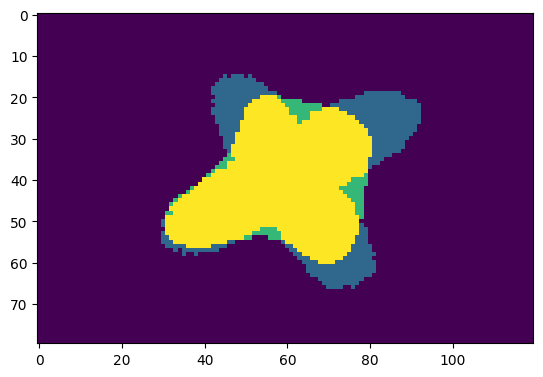

In [10]:
import matplotlib.pyplot as plt 

result = "result/summary_all.csv"
result_file = Path(result)
fieldnames = ['IDX', 'log path', 'object', 'wrench gt', 'wrench est', 'wrench error', 'p_thres', 'IoU']

if result_file.is_file(): 
    with open(result, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            print(row)

else:
    with open(result, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

result_dict = {}
for SEQ_IDX in indexs:
    result_dir = f"result/{SEQ_IDX}"
    if not os.path.isdir(f"result/{SEQ_IDX}"):
        os.mkdir(result_dir)

    SEQ_IDX_ = SEQ_IDX-40 if data_name == 'bubble_v2_tactile_shadowing_data_only_o_45' else SEQ_IDX

    (
        obs_pcd,
        wall_coords,
        outer_coords, 
        E,
        P,
        t, 
        nu,
        a, 
        b,
        L,
        L_e,
        etc,
    ) = get_dataset(N=20000, SEQ_IDX = SEQ_IDX_, data_name = data_name)
    
    
    E = E / (L **2)   # rubber 0.1 GPa (N/m**2)
    P = P / (L **2)
    t = t * L# 0.3 mm
    a, b = a*L, b*L
    wall_coords = wall_coords * L
    obs_pcd = obs_pcd * L
    outer_coords = outer_coords * L
    
    data_i = dataset[SEQ_IDX_]
    bubble_pc_bf = obs_pcd

    # Load stl
    tool_name = data_i['shape_id']
    mesh_path = get_mesh_path(f'pressing_shapes/{tool_name}.stl')
    tool_mesh = load_mesh(mesh_path)

    bubble_pc_bcf = data_i['bubble_pointcloud_cf']
    w_X_stl = data_i['world_X_stl']
    w_X_bcf = data_i['w_X_bcf']
    w_X_sf = data_i['w_X_sf']

    
    stl_X_bcf = np.linalg.inv(w_X_stl) @ w_X_bcf
    bubble_pc_stl = tr_pointcloud(bubble_pc_bcf, T=stl_X_bcf)  # (H, W, 3 or 6)
    # Ground Truth Contact
    contact_mask_r = get_bubble_tool_contact_points_sdf(bubble_pc_bcf[np.newaxis,...], 
                                                            tool_name, 
                                                            w_X_bcf, 
                                                            w_X_sf, 
                                                            contact_threshold=0.0003)


    config = get_config()
    CONFIG_NAME = 'configs/ts.py'
    ckpt_path = os.path.join(".", "ckpt", CONFIG_NAME)
    
    model = models.Membrane(
            config,
            wall_coords,
            obs_pcd,
            outer_coords,
            E, P, t, nu, a, b, L, L_e,
        )
    ckpt_path = os.path.join(".", "ckpt", f"{SEQ_IDX}")
    model.state = restore_checkpoint(model.state, ckpt_path)
    params = model.state.params

    u_pred = model.u_pred_fn(params, outer_coords[:,0], outer_coords[:,1])
    v_pred = model.v_pred_fn(params, outer_coords[:,0], outer_coords[:,1])
    w_pred = model.w_pred_fn(params, outer_coords[:,0], outer_coords[:,1])
    f_pred = model.f_pred_fn(params, outer_coords[:,0], outer_coords[:,1])
    
    f_pred = np.clip(f_pred, 0., np.inf)
    s = (outer_coords[2,0] - outer_coords[1,0]) #/L # pointcloud should be ordered
    
    # Convert back the scale
    x_hat = outer_coords[:, 0]/L + u_pred/L
    y_hat = outer_coords[:, 1]/L + v_pred/L
    z_hat = w_pred/L
    
    pcd = np.concatenate([x_hat[..., np.newaxis],
                          y_hat[..., np.newaxis],
                          z_hat[..., np.newaxis]], axis = 1)
    
    # Ground truth wrench
    wrench_w = np.linalg.norm(np.array(data_i['wrench_w'][:3])) # (N, 6)
    
    # s = (outer_coords[2,0] - outer_coords[1,0])/L # pointcloud should be ordered
    cnt_fc = np.sum(f_pred) * s**2

    #Define a regular grid over the data
    xr = np.linspace(-0.06, 0.06, 120)
    yr= np.linspace(-0.04, 0.04, 80)
    xr, yr = np.meshgrid(xr, yr)
    
    #evaluate the z-values at the regular grid through cubic interpolation
    Z = griddata((x_hat, y_hat), f_pred * L**2, (xr, yr))
    
    Z_cnt = griddata((bubble_pc_bf.reshape(-1, 3)[:,0]/L, 
                      bubble_pc_bf.reshape(-1, 3)[:,1]/L), 
                     contact_mask_r.reshape(-1)*255, (xr, yr))
    ellipse_area = sum(not np.isnan(x) for x in Z.reshape(-1))

    #evaluate the z-values at the regular grid through cubic interpolation
    Z = np.nan_to_num(Z)
    Z_cnt = np.nan_to_num(Z_cnt)


    
    # Contact Mask Prediction
    average = (np.sum(Z)/ellipse_area) * 2
    p_thres = max(2.5e3, average) # TODO: This is tunable
    cnt_est_real = np.where( Z < p_thres, np.zeros_like(Z), np.ones_like(Z))
    Z_cnt_real = np.where( Z_cnt == 0, np.zeros_like(Z_cnt), np.ones_like(Z_cnt))

    iou = binary_mask_iou (Z_cnt_real,  cnt_est_real)
    plt.imshow(Z_cnt_real+cnt_est_real*2)
    plt.savefig(f"{result_dir}/iou_{SEQ_IDX}.png")


    result_dict[SEQ_IDX]= {"grid": np.stack([ outer_coords[:, 0]/L,  outer_coords[:, 1]/L], axis = 1),
                           "deformation": np.stack([ u_pred/L,  v_pred/L,  w_pred/L], axis = 1), 
                           "pressure": f_pred * L**2, 
                           "mask_gt": Z_cnt_real, 
                           "mask_est": cnt_est_real,
                          "wrench_gt": data_i['wrench_w'],
                          "wrench_est": cnt_fc}
            
    with open(result, 'a', newline='') as csvfile:  
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({'IDX': SEQ_IDX, 
                         'log path':ckpt_path, 
                         'object': tool_name, 
                         'wrench gt': wrench_w, 
                         'wrench est': cnt_fc, 
                         'wrench error': abs( wrench_w - cnt_fc), 
                         "p_thres": p_thres, 
                         'IoU':iou})
  

In [15]:

import pickle
save_name =  "result/result_dict.pkl" if not data_name == 'bubble_v2_tactile_shadowing_data_only_o_45' else  "result/result_dict_o_45.pkl"
with open(save_name, 'wb') as f:
    pickle.dump(result_dict, f)  

In [14]:
save_name =  "result/result_dict.pkl" if not data_name == 'bubble_v2_tactile_shadowing_data_only_o_45' else  "result/result_dict_o_45.pkl"
save_name

        

'result/result_dict.pkl'

In [4]:
data_name == 'bubble_v2_tactile_shadowing_data_only_o_45'

False